(1000, 128, 128, 3)


c:\Users\grant\anaconda3\envs\tf-gpu2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

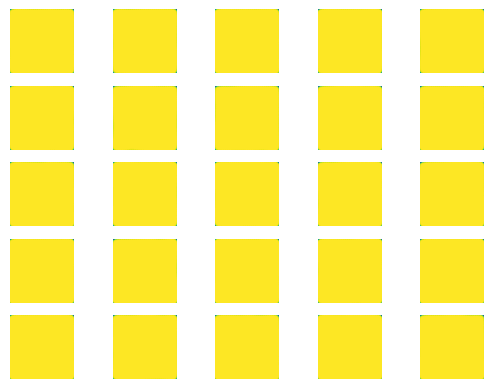

In [1]:

import numpy as np
from numpy.random import randn, randint
from numpy import asarray

import random

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt

from PIL import Image

import cv2

import imageio


import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/bin")

#################################################################################
n = 1000
x_size, y_size = 128,128
epochs = 10
batch_size = 32
AUTO = tf.data.AUTOTUNE
output_path = 'C:/Users/grant/OneDrive/Desktop/git_projects/python_envs/ATMAN_GAN/GAN/GAN_outputs/'
########################## DATA LOAD ############################################
# Batched Data Loader required? 

#Preparing data pathway
input_dir = 'C:/Users/grant/OneDrive/Desktop/git_projects/python_envs/ATMAN_GAN/GAN/datasets/landscape/'

input_img_paths = sorted(
    [
        os.path.join(input_dir,fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.jpg')
    ]
)

#selecting n random images for training
input_img_paths = random.sample(input_img_paths, n)



########################## IMAGE PRE-PROCESSOR ############################################

dataset = []
save_path = 'C:/Users/grant/OneDrive/Desktop/git_projects/python_envs/ATMAN_GAN/GAN/datasets/landscape_clean/'
for j, path in enumerate(input_img_paths):
	img = cv2.imread(path)
	RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	img_r = cv2.resize(RGB_img,dsize=(x_size,y_size),interpolation=cv2.INTER_CUBIC)
	dataset.append(img_r)
dataset = np.asarray(dataset)
print(dataset.shape)
########################### DESCRIMINATOR #################################################
# Input should be 128x128x3 images and the output would be a binary (using sigmoid)
# Binary classification (True/False)

def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 64x64
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8x8
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

#Verify the model summary
test_discr = define_discriminator()
print(test_discr.summary())
plot_model(test_discr,to_file=os.path.join(output_path,'discrim_model.png'), show_shapes=True)


########################### GENERATOR #####################################################
# Generator generates 128x128x3 images that can be fed into the discriminator.
# Start with enough nodes in the dense layer that can be gradually upscaled to 128x128x3.
#Input would be a latent vector (usually size 100)


def define_generator(latent_dim):
	model = Sequential()
	# Define number of nodes that can be gradually reshaped and upscaled to 128x128x3
	n_nodes = 128 * 8 * 8 #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 128x128x3
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #tanh goes from [-1,1]
	return model

test_gen = define_generator(100)
print(test_gen.summary())
plot_model(test_gen,to_file=os.path.join(output_path,'generator_model.png'), show_shapes=True)

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())
plot_model(test_gan, to_file=os.path.join(output_path,'combined_model.png'), show_shapes=True)


# Function to sample some random real images
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1)) # Class labels for real images are 1
	return X, y

# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator. 
	return x_input

# Function to generate fake images using latent vectors
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples) #Generate latent points as input to the generator
	X = g_model.predict(x_input) #Use the generator to generate fake images
	y = np.zeros((n_samples, 1)) # Class labels for fake images are 0
	return X, y

# Function to save Plots after every n number of epochs
def save_plot(examples, epoch, n=10):
	# scale images from [-1,1] to [0,1] so we can plot
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
	# save plot to a file so we can view how generated images evolved over epochs
	fname = 'generated_plot_128x128_e%03d.png' % (epoch+1)
	new_path = os.path.join(output_path,fname)
	plt.savefig(fname)
	plt.close()

# Function to summarize performance periodically. 
# 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# Fetch real images
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real images - get accuracy
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# Generate fake images
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake images - get accuracy
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# Print discriminate accuracies on ral and fake images. 
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save generated images periodically using the save_plot function
	save_plot(x_fake, epoch)
	# save the generator model
	fname = 'generator_model_128x128_%03d.h5' % (epoch+1)
	new_path = os.path.join(output_path,fname)
	g_model.save(new_path)

# train the generator and discriminator by enumerating batches and epochs. 
#
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=epochs, n_batch=batch_size):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2) #Disc. trained on half batch real and half batch fake images
	#  enumerate epochs
	for i in range(n_epochs):
		# enumerate batches 
		for j in range(bat_per_epo):
			# Fetch random 'real' images
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# Train the discriminator using real images
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' images 
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# Train the discriminator using fake images
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# Generate latent vectors as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# Label generated (fake) mages as 1 to fool the discriminator 
			y_gan = np.ones((n_batch, 1))
			# Train the generator (via the discriminator's error)
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# Report disc. and gen losses. 
			print('Epoch>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

############################################

#Rescale to [-1, 1] - remember that the generator uses tanh activation that goes from -1,1
# dataset = dataset.astype('float32')
	# scale from [0,255] to [-1,1]
# dataset = (dataset - 127.5) / 127.5

# size of the latent space
latent_dim = 100
# create the discriminator using our pre-defined function
d_model = define_discriminator()
# create the generator using our pre-defined function
g_model = define_generator(latent_dim)
# create the gan  using our pre-defined function
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=epochs)
print('TRAIN COMPLETE')
# size of the latent space
latent_dim = 100
# define the discriminator model
# generate samples
n_samples = 25
X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis labels
 plt.axis('off')
 # plot single image
 plt.imshow(X[i, :, :, 0])
# show the figure
plt.savefig('output_example.png')
